In [2]:
import numpy as np
from scipy.integrate import odeint
import matplotlib.pyplot as plt
import pandas as pd
import matplotlib.dates as mdates
from datetime import datetime, timedelta, date
from sympy import symbols, solve

In [3]:
import warnings
warnings.filterwarnings("ignore")

## SIRD model in Python 

In [4]:
def deriv(y, t, N, beta, gamma, rho):
    S, I, R, D= y
    dSdt = -(beta * S * I) / N
    dIdt = (beta * S * I / N) - (gamma * I) - (rho * I)
    dRdt = gamma * I
    dDdt = rho * I
    return dSdt, dIdt, dRdt, dDdt

## Graph SIRD model

In [25]:
def plotSIRD(ax, tf, N, i0, beta, gamma, rho, ylimit, xlimit, sd, offset, sird_true):
    t = np.linspace(0, tf, tf)

    y0 = N-i0, i0, 0, 0

    # Integrate the SIR equations over the time grid, t.
    ret = odeint(deriv, y0, t, args=(N, beta, gamma, rho))
    S, I, R, D = ret.T

    # SD SIR equation
    ret = odeint(deriv, y0, t, args=(N, beta-sd[0], gamma-sd[1], rho-sd[2]))
    Sm, Im, Rm, Dm = ret.T 

    # SD SIR equation
    ret = odeint(deriv, y0, t, args=(N, beta+sd[0], gamma+sd[1], rho+sd[2]))
    Sp, Ip, Rp, Dp = ret.T 


    # Plotting SIRD data point
    if (sird_true):
        ax.plot(t+offset, S, 'b', alpha=0.5, lw=2, label='Susceptible')
        ax.plot(t+offset, I, 'r', alpha=0.5, lw=2, label='Infected')
        ax.plot(t+offset, R, 'g', alpha=0.5, lw=2, label='Recovered')
        ax.plot(t+offset, D, 'y', alpha=0.5, lw=2, label='Deceased')
    else:
        ax.plot(t+offset, D, alpha=1, lw=2, label='Deceased')


    # Creating Labels for graph
    ax.set_xlabel('Time /days')
    ax.set_ylabel('Deceased')
    ax.yaxis.set_tick_params(length=0)
    ax.xaxis.set_tick_params(length=0)
    ax.grid(b=True, which='major', c='w', lw=2, ls='-')
    ax.set_xlim([xlimit[0], xlimit[1]])
    ax.set_ylim([ylimit[0], ylimit[1]])
    ax.fill_between(t+offset, Dm, Dp, alpha=0.2, edgecolor='black',  label="Standard Deviation")
    for spine in ('top', 'right', 'bottom', 'left'):
        ax.spines[spine].set_visible(False)
    return D
    

In [45]:
def plotRealData (graph, data, offset, beforeForecast, D, minus, manipulate=False):
    if (manipulate==False):
        deaths = data["cumDeath"].tolist()
        deaths = [x-minus for x in deaths]
    else:
        deaths = data["cumDeath"]-data["cumDeath"].loc[offset]
        deaths = deaths.to_list()
        deaths = [x+minus for x in deaths]
    t = np.linspace(0, 700, 700)
    if (offset != 0):
        graph.plot(t[0:offset], deaths[0:offset], 'r', marker='.', linestyle = 'None')
        graph.plot(t[offset:beforeForecast], deaths[offset:beforeForecast], 'r', marker='x', label="Observed Data", linestyle = 'None')
        graph.plot(t[beforeForecast:len(t)], deaths[beforeForecast:len(t)], 'r', marker='.', label="Unseen Data", linestyle = 'None')
    else:
        graph.plot(t[0:beforeForecast], deaths[0:beforeForecast], 'r', marker='x', label="Observed Data", linestyle = 'None')
        graph.plot(t[beforeForecast:len(t)], deaths[beforeForecast:len(t)], 'r', marker='.', label="Unseen Data", linestyle = 'None')
    legend = graph.legend()
    legend.get_frame().set_alpha(0.5)
    return graph
    

## Bulk 

In [7]:
def addTime(startDate, t): 
    dates = datetime.strptime(startDate, '%Y-%m-%d').date()
    d = dates+ timedelta(days = t)
    return d.strftime('%Y-%m-%d')
def timeTot(startDate, endDate):
    sD = startDate.split('-')
    sDs = date(int(sD[0]),int(sD[1]),int(sD[2]))
    eD = endDate.split('-')
    eDs = date(int(eD[0]),int(eD[1]),int(eD[2]))
    delta = eDs - sDs
    return delta.days

In [9]:
dataset = {
    'France': {
        'data' : pd.read_csv("../processed_data/cumDeathFrance.csv"),
        'fLock' : ['2020-03-17','2020-05-11'],
        'sLock' : ['2020-10-30','2020-12-15'],
        'pop' : 67413000
             },
    'Italy' : {
        'data' : pd.read_csv("../processed_data/cumDeathItaly.csv"),
        'fLock' : ['2020-03-09','2020-05-18'], 
        'sLock' : ['2020-12-24','2021-01-06'],
        'pop': 59110000
              },
    'Spain' : {
        'data' : pd.read_csv("../processed_data/cumDeathSpain.csv"),
        'fLock' : ['2020-03-14','2020-05-09'], 
        'sLock' : ['2020-11-03','2021-02-03'],
        'pop' : 47420000
              },
    'Germany' : {
        'data' : pd.read_csv("../processed_data/cumDeathGermany.csv"),
        'fLock' : ['2020-03-16','2020-05-30'], 
        'sLock' : ['2020-11-02','2021-03-01'],
        'pop' : 83000000
                },
    'UK' : {
        'data' : pd.read_csv("../processed_data/cumDeathUK.csv"),
        'fLock' : ['2020-03-23','2020-07-04'], 
        'sLock' : ['2020-11-05','2021-03-28'],
        'pop' : 67330000
           },
    'Switzerland' : {
        'data' : pd.read_csv("../processed_data/cumDeathSwitzerland.csv"),
        'fLock' : ['2020-03-17', '2020-04-27'],
        'sLock' : ['2021-01-18', '2021-03-01'],
        'pop' : 8570146
            },
    'Netherlands' : {
        'data' : pd.read_csv("../processed_data/cumDeathNetherlands.csv"),
        'fLock' : ['2020-03-15', '2020-04-06'],
        'sLock' : ['2020-12-15', '2021-06-05'],
        'pop' : 17606800
            },
}


## First Lockdown

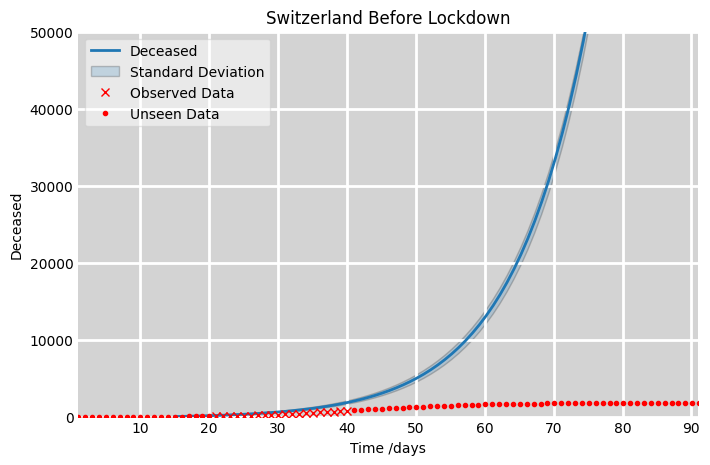

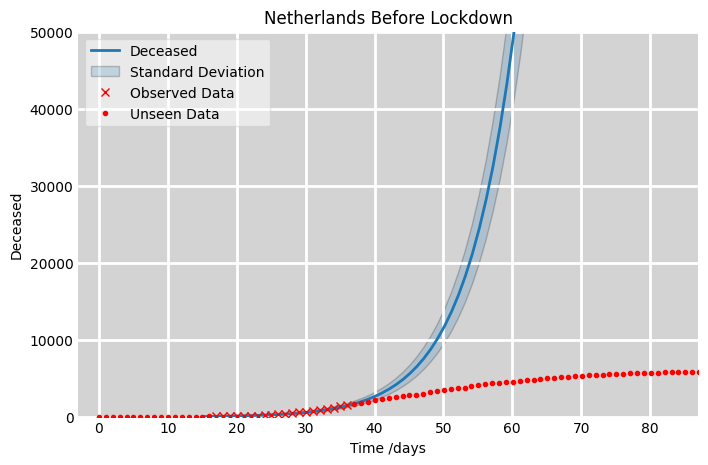

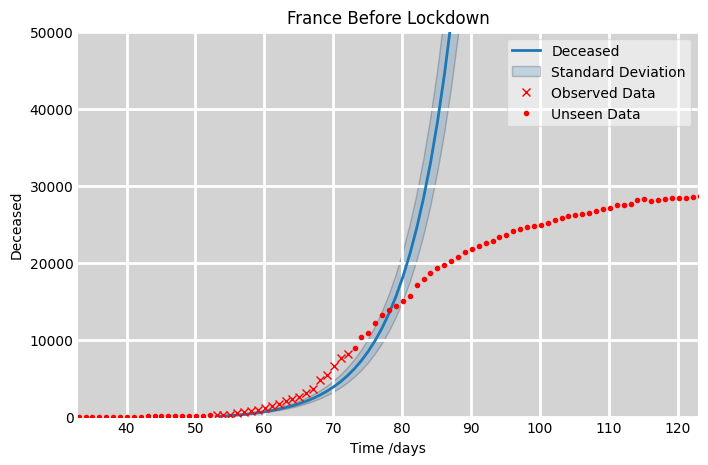

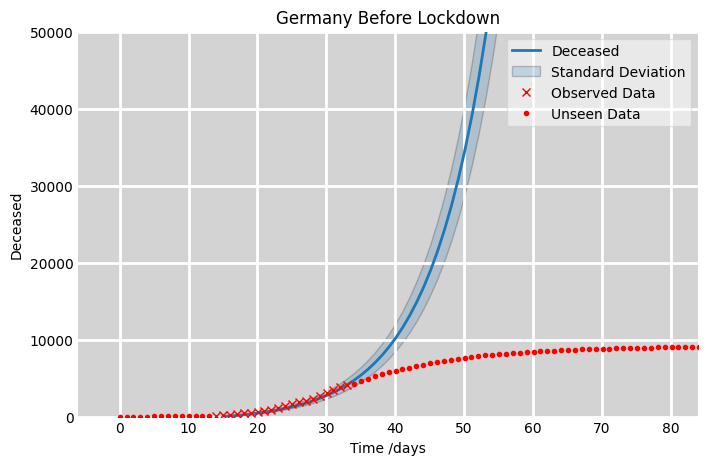

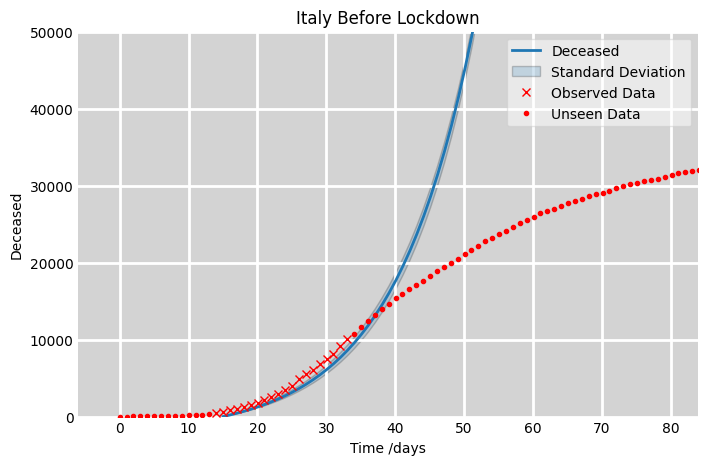

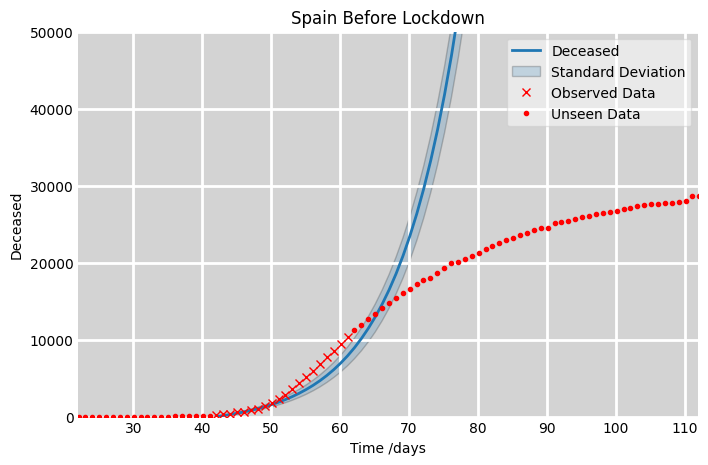

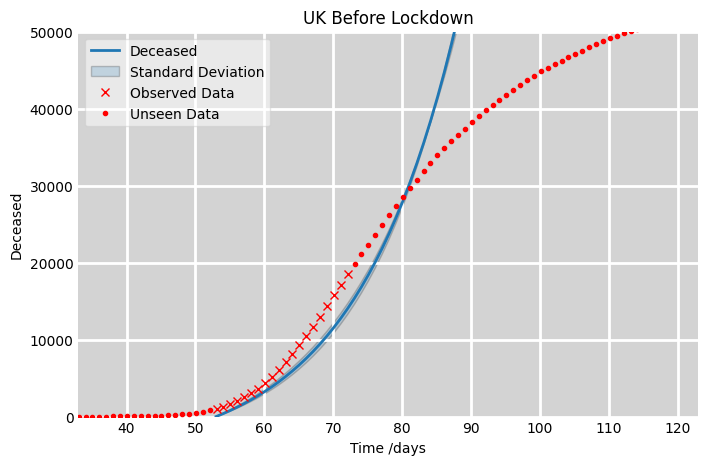

In [52]:
country_names = ['Switzerland', 'Netherlands', 'France','Germany','Italy','Spain','UK']
sird_deaths = {}
for country in country_names:
    fig, ax1 = plt.subplots(1,1, figsize=(8,5))    
    ax1.set_facecolor('lightgrey')
    # Plot the data on three separate curves for S(t), I(t) and R(t)
    
    pop = dataset[country]['pop']
    startDate = dataset[country]['fLock'][0]
    realData = pd.read_csv('../processed_data/cumDeath'+country+'.csv')
    firstDate = realData.loc[0]['date']
    
    offset = timeTot(firstDate,startDate)-15
    if (offset > 20):
        offset = 0
    # before
    obvData_start = timeTot(firstDate,startDate)
    obvData_end = timeTot(firstDate,addTime(startDate,20))
    df = pd.read_csv('mcmc_data/'+country+"/fLock_before.csv")
    graph = plotSIRD(ax1,200, pop, df.loc[3][1], df.loc[0][1], df.loc[1][1], df.loc[2][1], [0,50000], [obvData_start-20,obvData_end+50], [df.loc[0][2], df.loc[1][2], df.loc[2][2]], timeTot(firstDate,startDate)-offset, False)
    sird_deaths[country] = {
        'deaths':graph,
        'date': obvData_end+30
    }
    ax1.set_title(country + " Before Lockdown")
    final_graph =plotRealData(ax1, realData, obvData_start, obvData_end, graph,0)
    plt.savefig('results/first_q/'+country+'.png')


### Quantifying difference

## Second lockdown

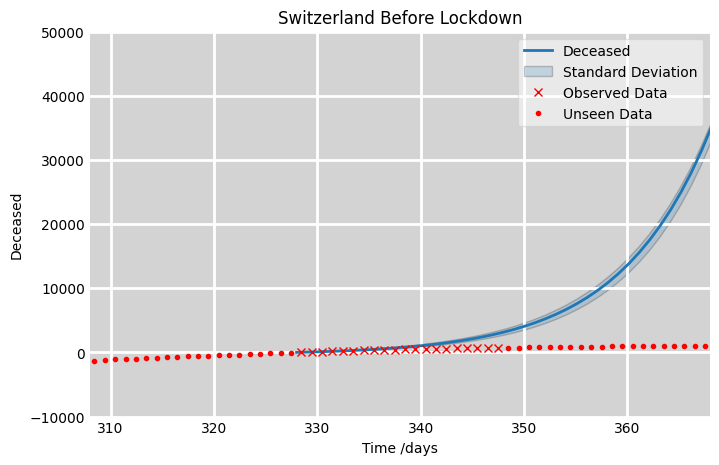

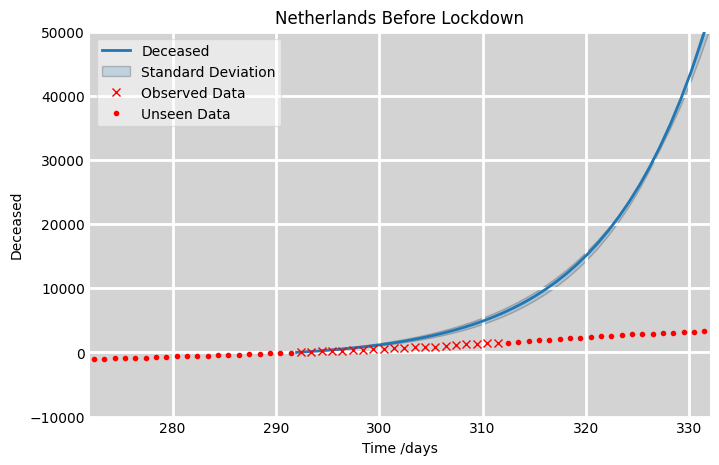

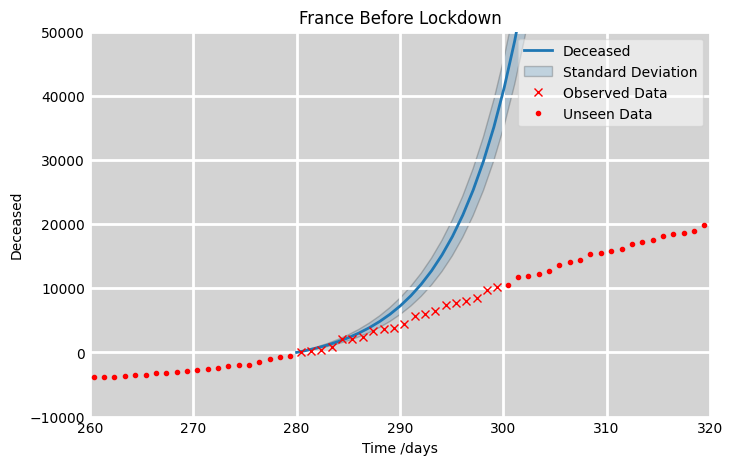

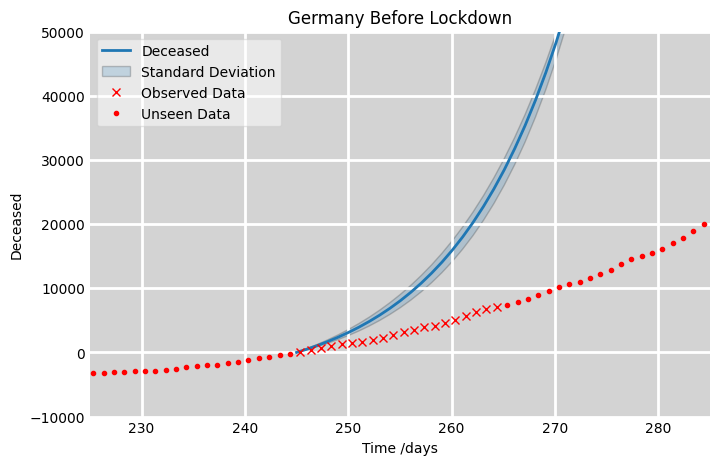

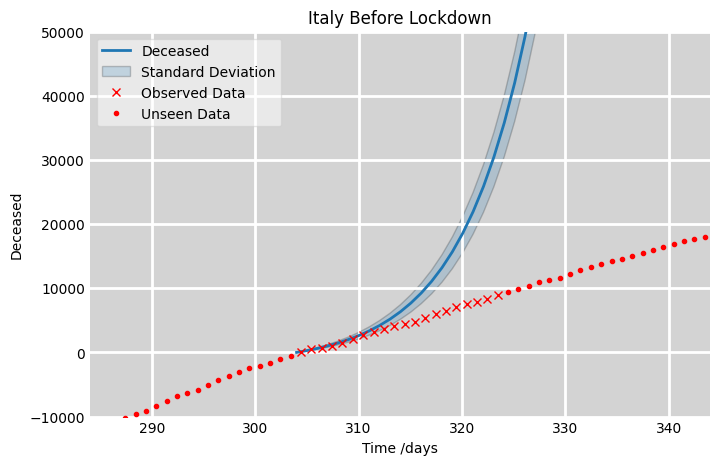

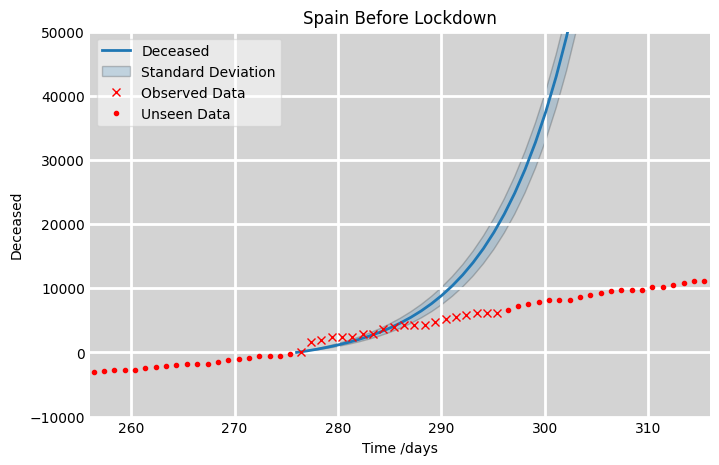

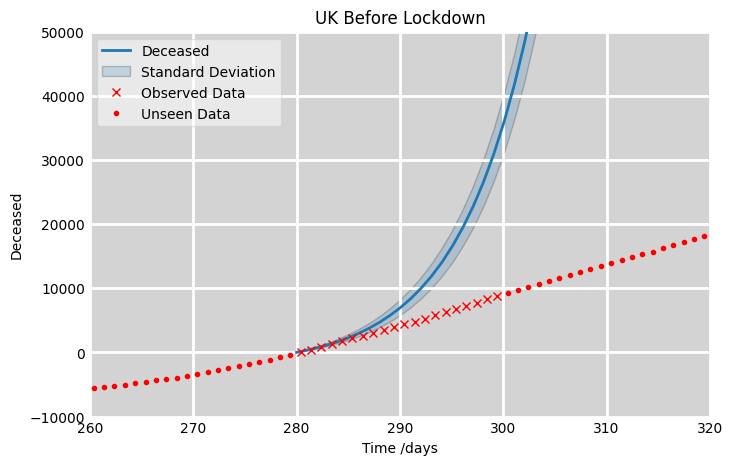

In [60]:
country_names = ['Switzerland','Netherlands','France','Germany','Italy','Spain','UK']
sird_deaths = {}
for country in country_names:
    fig, (ax1) = plt.subplots(1,1, figsize=(8,5))    
    ax1.set_facecolor('lightgrey')
    # Plot the data on three separate curves for S(t), I(t) and R(t)
    
    pop = dataset[country]['pop']
    startDate = dataset[country]['sLock'][0]
    realData = pd.read_csv('../processed_data/cumDeath'+country+'.csv')
    firstDate = realData.loc[0]['date']

    obvData_start = timeTot(firstDate,startDate)
    obvData_end = timeTot(firstDate,addTime(startDate,20))
    add = dataset[country]['data'].iloc[[obvData_start]]['cumDeath']
    df = pd.read_csv('mcmc_data/'+country+"/sLock_before.csv")
    graph = plotSIRD(ax1,200, pop, df.loc[3][1], df.loc[0][1], df.loc[1][1], df.loc[2][1], [-10000,50000], [obvData_start-20,obvData_end+20], [df.loc[0][2], df.loc[1][2], df.loc[2][2]], timeTot(firstDate,startDate), False)
    plotRealData(ax1, realData, obvData_start, obvData_end, graph, 0, True)
    ax1.set_title(country + " Before Lockdown")
    plt.savefig('results/second_q/'+country+'.png')
